Read in data and label it normal or anomalous

In [2]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import pandas as pd
from pathlib import Path
import numpy as np
import csv

dir_path= Path('..', 'data')
data_path= Path(dir_path,'edt_DS.csv' )
data_file= pd.read_csv(data_path)
print(data_file.columns)
data_file=data_file.drop(columns=[' id', ' who CH' ,' Time', ' Dist_To_CH', 'Rank', ' dist_CH_To_BS', ' send_code '])

x= data_file.values
print(x.shape)

shp= int(x.shape[0])

y=np.empty((shp, 1), dtype=str)
count=0
for a in x:
    if a[11] =='Normal':
        y[count]='N'
    else:
        y[count]='A'
    count=count+1
    
#print(x.shape )
#print (y.shape)
xtrain, xtest, ytrain, ytest = train_test_split(data_file.values,y,train_size=0.6, stratify= data_file['Attack type'])
        
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)
#print(ytrain)
myfile= open('traintest.csv', 'w')
#print(xtrain)
with myfile:
    writer= csv.writer(myfile)
    writer.writerow(data_file.columns)
    writer.writerows(xtrain)
    writer.writerows(xtest)

ys= open('labels.csv', 'w')
with ys:
    writer=csv.writer(ys)
    writer.writerows(ytrain)
    writer.writerows(ytest)

Index([' id', ' Time', ' Is_CH', ' who CH', ' Dist_To_CH', ' ADV_S', ' ADV_R',
       ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R', 'Rank', ' DATA_S', ' DATA_R',
       ' Data_Sent_To_BS', ' dist_CH_To_BS', ' send_code ', 'Consumed Energy',
       'Attack type'],
      dtype='object')
(371349, 12)
(222809, 12)
(148540, 12)
(222809, 1)
(148540, 1)


read in anomalous/normal data

In [3]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import pandas as pd
from pathlib import Path
import numpy as np

data_path= Path('traintest.csv' )
data_file= pd.read_csv(data_path)
data_file=data_file.drop(columns=['Attack type'])

print(data_file.columns)
allx= data_file.values
#print(allx.shape)
xtrain= allx[0:222809]
xtest= allx[222809: 222809+148540]

# print(xtrain.shape)
# print(xtest.shape)



Index([' Is_CH', ' ADV_S', ' ADV_R', ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R',
       ' DATA_S', ' DATA_R', ' Data_Sent_To_BS', 'Consumed Energy'],
      dtype='object')


build classifier

In [4]:
cls=DecisionTreeClassifier()

cls=cls.fit(xtrain,ytrain)

y_pred=cls.predict(xtest)

test trees

In [19]:
print("Accuracy:", metrics.accuracy_score(ytest, y_pred))


print(metrics.classification_report(ytest, y_pred))

Accuracy: 0.9738252322606705
              precision    recall  f1-score   support

           A       0.77      0.99      0.86     12513
           N       1.00      0.97      0.99    136027

    accuracy                           0.97    148540
   macro avg       0.88      0.98      0.92    148540
weighted avg       0.98      0.97      0.98    148540



add flooding to test dataset

In [6]:
dir_path= Path('..', 'data')
data_path= Path(dir_path,'flooding.csv' )
data_file= pd.read_csv(data_path)
print(data_file.columns)
data_file=data_file.drop(columns=[' id', ' who CH' ,' Time', ' Dist_To_CH', 'Rank', ' dist_CH_To_BS', ' send_code ','Attack type' ])
data_dump=data_file.values



x_ftest= np.concatenate((xtest, data_dump), 0)
yflood=np.empty((data_dump.shape[0], 1), dtype=str)
count=0
for a in yflood:
    yflood[count]='A'
    count=count+1
    
y_ftest= np.concatenate((ytest, yflood),0)


Index([' id', ' Time', ' Is_CH', ' who CH', ' Dist_To_CH', ' ADV_S', ' ADV_R',
       ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R', 'Rank', ' DATA_S', ' DATA_R',
       ' Data_Sent_To_BS', ' dist_CH_To_BS', ' send_code ', 'Consumed Energy',
       'Attack type'],
      dtype='object')


save new dataset


In [7]:
myfile= open('test_wt_flooding.csv', 'w')
#print(xtrain)
with myfile:
    writer= csv.writer(myfile)
    writer.writerow(data_file.columns)
    writer.writerows(x_ftest)

ys= open('labels_wt_flooding.csv', 'w')
with ys:
    writer=csv.writer(ys)
    writer.writerows(ytrain)
    writer.writerows(y_ftest)

test classifier on new test data

In [8]:
y_floodpred=cls.predict(x_ftest)

print("Accuracy:", metrics.accuracy_score(y_ftest, y_floodpred))

Accuracy: 0.974501488291231


In [9]:
y_flood_only=cls.predict(data_dump)

print("Accuracy:", metrics.accuracy_score(yflood, y_flood_only))

Accuracy: 0.009359903381642512


examine the tree

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# plt.figure()
# plot_tree(cls, filled=True)
# plt.show()
# plt.savefig('first_tree.png')

that is MASSIVE (probably why it can't pick up on unseen hacks)
gonna prune

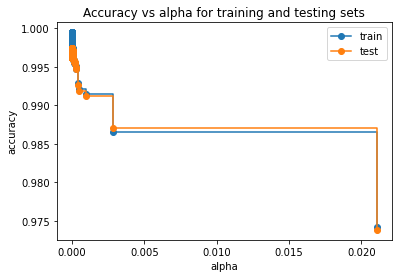

In [12]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(xtrain, ytrain)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]


train_scores = [clf.score(xtrain, ytrain) for clf in clfs]
test_scores = [clf.score(xtest, ytest) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()




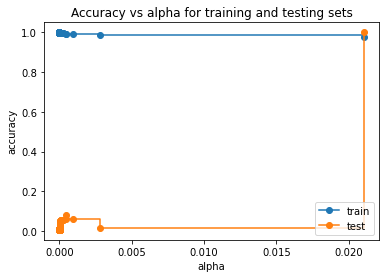

In [13]:
test_scores = [clf.score(data_dump, yflood) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

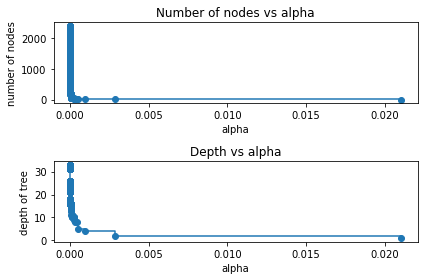

In [14]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [20]:
y_floodpred=clfs[-1].predict(data_dump)

print("Accuracy:", metrics.accuracy_score(yflood, y_floodpred))
#print("Accuracy:", metrics.accuracy_score(y_ftest, y_floodpred))
print(metrics.classification_report(yflood, y_floodpred))

Accuracy: 1.0
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      3312

    accuracy                           1.00      3312
   macro avg       1.00      1.00      1.00      3312
weighted avg       1.00      1.00      1.00      3312



In [16]:
KO= clfs[-1]

y_floodpred=KO.predict(x_ftest)

#print("Accuracy:", metrics.accuracy_score(y_ftest, y_floodpred))
print(metrics.classification_report(y_ftest, y_floodpred))

              precision    recall  f1-score   support

           A       0.81      0.99      0.89     15825
           N       1.00      0.97      0.99    136027

    accuracy                           0.97    151852
   macro avg       0.90      0.98      0.94    151852
weighted avg       0.98      0.97      0.98    151852



In [18]:
y_pred=KO.predict(xtest)
print("Accuracy:", metrics.accuracy_score(ytest, y_pred))
print(metrics.classification_report(ytest, y_pred))

Accuracy: 0.9738252322606705
              precision    recall  f1-score   support

           A       0.77      0.99      0.86     12513
           N       1.00      0.97      0.99    136027

    accuracy                           0.97    148540
   macro avg       0.88      0.98      0.92    148540
weighted avg       0.98      0.97      0.98    148540



lets take a look at the tree now

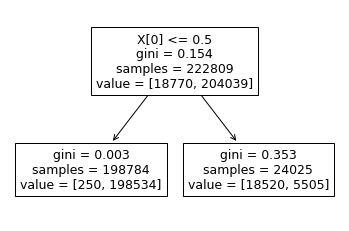

In [104]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure()
plot_tree(KO)
plt.show()

So KO is pruned and works for unknown hacks at the cost of accuracy on known hacks. (dropped from 0.9954759660697455 to 0.9739531439342938)
now we calibrate and boost KO to improve accuracy